In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import csv

import warnings
warnings.filterwarnings("ignore")

In [2]:
setting = "wd=0.01_lr=3e-5"

In [3]:
def read_nodes(file_path):
    int_list = []
    with open(file_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            for item in row:
                try:
                    int_list.append(int(item))
                except ValueError:
                    print(f"Warning: '{item}' could not be converted to an integer and was skipped.")
    return int_list

def calculate_one(path, setting):
    try:
        score = torch.load(path, map_location=torch.device('cpu'))
        score /= 2048 ** 0.5

        # Prepare node list
        nodes_str = [f"./checkpoints/{setting}/{i}/train_index.csv" for i in range(50)]
        full_nodes = list(range(4656))
        node_list = []
        for node_str in nodes_str:
            numbers = read_nodes(node_str)
            index = [full_nodes.index(number) for number in numbers]
            node_list.append(index)

        # Load ground truth
        loss_list = torch.load(f"./results/{setting}/gt.pt", map_location=torch.device('cpu')).detach()

        # Calculate approximations
        approx_output = []
        for i in range(len(nodes_str)):
            score_approx_0 = score[node_list[i], :]
            sum_0 = torch.sum(score_approx_0, axis=0)
            approx_output.append(sum_0)

        # Calculate correlations
        res = 0
        counter = 0
        for i in range(score.shape[1]):
            tmp = spearmanr(
                np.array([approx_output[k][i] for k in range(len(approx_output))]),
                np.array([loss_list[k][i].numpy() for k in range(len(loss_list))])
            ).statistic
            if not np.isnan(tmp):
                res += tmp
                counter += 1

        return res/counter if counter > 0 else float('nan'), loss_list, approx_output
    except (FileNotFoundError, RuntimeError) as e:
        return None, None, None

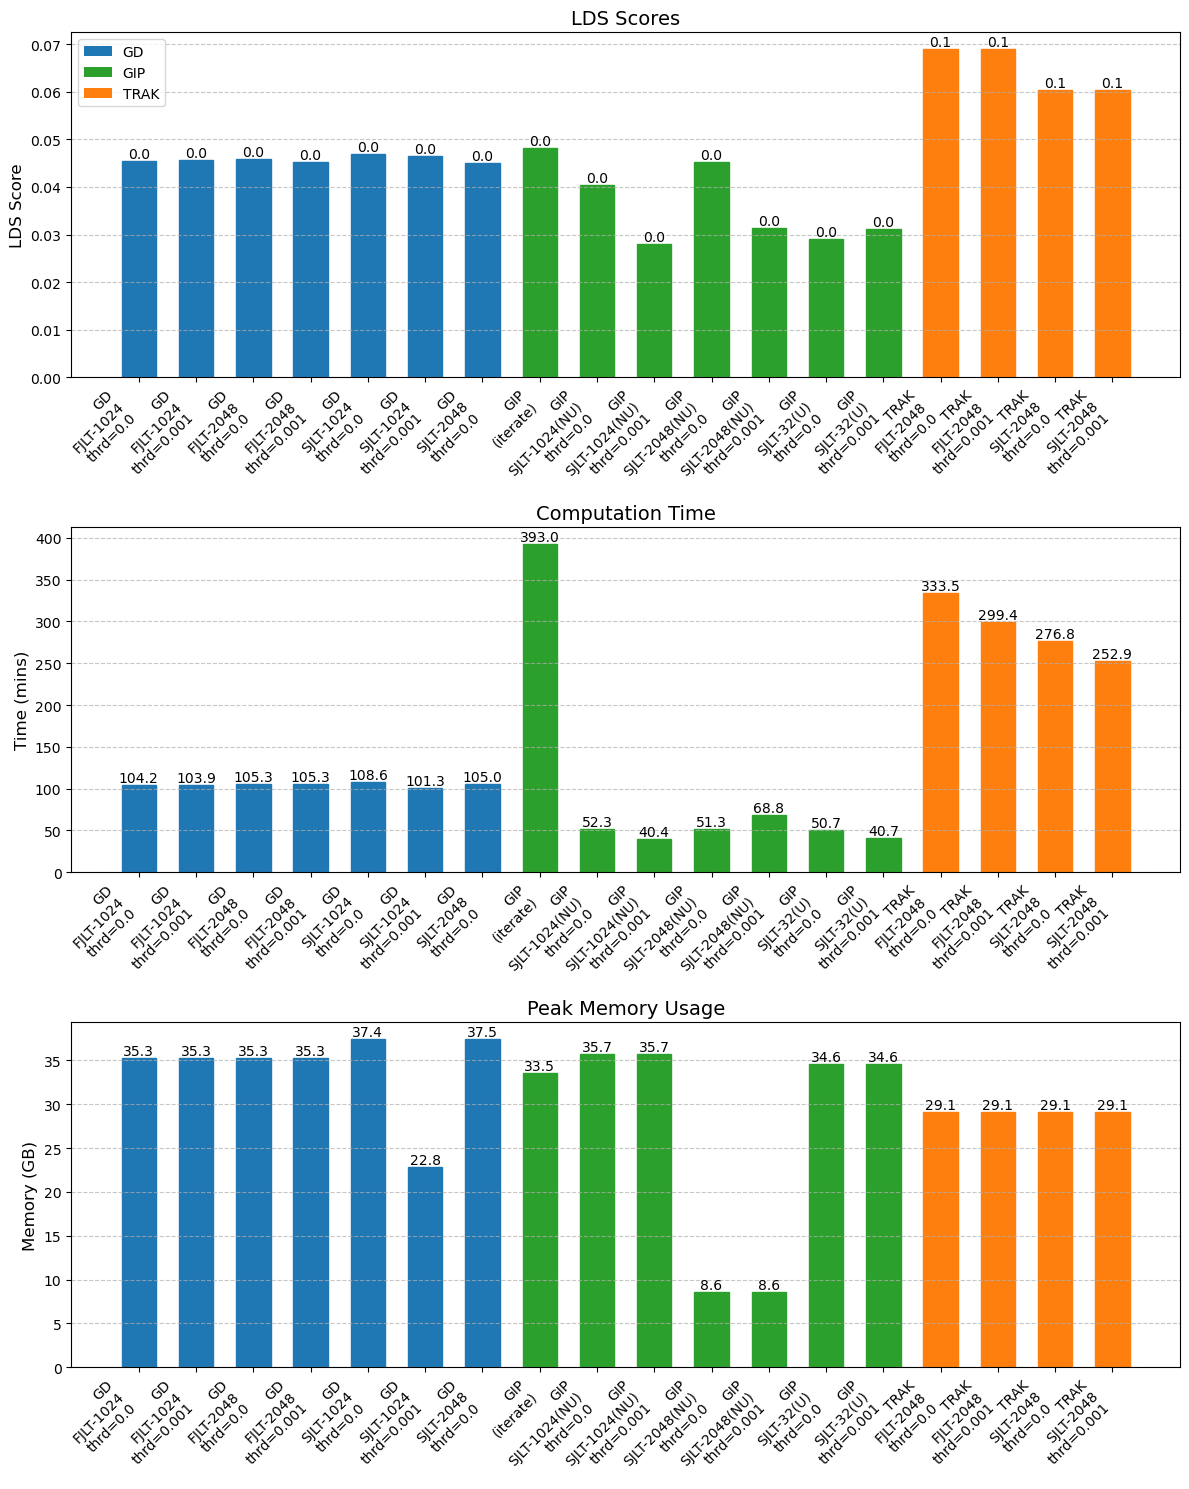

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import re

def extract_from_log(log_path):
    try:
        with open(log_path, 'r') as f:
            content = f.read()

            # Extract time
            time_match = re.search(r'Time taken: (\d+\.?\d*) seconds', content)
            time_taken = float(time_match.group(1)) if time_match else None

            # Extract memory
            memory_match = re.search(r'Peak memory usage: (\d+\.?\d*) MB', content)
            peak_memory = float(memory_match.group(1)) if memory_match else None

            return time_taken/60, peak_memory/1024  # Convert seconds to minutes and MB to GB
    except FileNotFoundError:
        return 0, 0

def visualize_comprehensive_results(setting):
    methods = {
        'GD': {
            'projections': ['FJLT-1024', 'FJLT-2048', 'SJLT-1024', 'SJLT-2048'],
            'thresholds': [0.0, 0.001],
            'pattern': lambda p, t: f"GD-default_{p}_thrd-{t}.pt"
        },
        'GIP': {
            'projections': ['SJLT-1024(NU)', 'SJLT-2048(NU)', 'SJLT-32(U)', 'FJLT-32(U)'],
            'thresholds': [0.0, 0.001],
            'pattern': lambda p, t: f"GIP-default_{p}_thrd-{t}.pt",
            'special': ['iterate']
        },
        'TRAK': {
            'projections': ['FJLT-2048', "SJLT-2048"],
            'thresholds': [0.0, 0.001],
            'pattern': lambda p, t: f"TRAK-default_{p}_thrd-{t}.pt"
        }
    }

    results = []
    times = []
    memories = []
    labels = []

    # Collect all results
    for method, config in methods.items():
        # Handle special cases first
        if 'special' in config:
            for special_case in config['special']:
                base_path = f"./results/{setting}/{method}-{special_case}"
                result = calculate_one(f"{base_path}.pt", setting)[0]
                time_taken, peak_memory = extract_from_log(f"{base_path}.log")

                if result is not None:
                    results.append(result)
                    times.append(time_taken)
                    memories.append(peak_memory)
                    labels.append(f"{method}\n(iterate)")

        # Handle standard cases
        for proj in config['projections']:
            for thrd in config['thresholds']:
                base_path = f"./results/{setting}/{config['pattern'](proj, thrd).replace('.pt', '')}"
                result = calculate_one(f"{base_path}.pt", setting)[0]
                time_taken, peak_memory = extract_from_log(f"{base_path}.log")

                if result is not None:
                    results.append(result)
                    times.append(time_taken)
                    memories.append(peak_memory)
                    labels.append(f"{method}\n{proj}\nthrd={thrd}")

    # Create the plot with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), height_ratios=[1, 1, 1])

    x = np.arange(len(results))
    width = 0.6

    colors = {'GD': '#1f77b4', 'GIP': '#2ca02c', 'TRAK': '#ff7f0e'}

    # Plot 1: LDS Scores
    bars1 = ax1.bar(x, results, width=width)
    ax1.set_ylabel('LDS Score', fontsize=12)
    ax1.set_title('LDS Scores', fontsize=14)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Time
    bars2 = ax2.bar(x, times, width=width)
    ax2.set_ylabel('Time (mins)', fontsize=12)
    ax2.set_title('Computation Time', fontsize=14)
    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Plot 3: Memory
    bars3 = ax3.bar(x, memories, width=width)
    ax3.set_ylabel('Memory (GB)', fontsize=12)
    ax3.set_title('Peak Memory Usage', fontsize=14)
    ax3.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Color all bars and add value labels
    for bars in [bars1, bars2, bars3]:
        for bar, label in zip(bars, labels):
            method = label.split('\n')[0]
            bar.set_color(colors[method])
            height = bar.get_height()
            if height is not None:  # Check if the value exists
                ax = bar.axes
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}',
                       ha='center', va='bottom')

    # Set x-axis labels for all plots
    for ax in [ax1, ax2, ax3]:
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha='right')

    # Add legend
    legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color, label=method)
                      for method, color in colors.items()]
    ax1.legend(handles=legend_elements, loc='upper left')

    # Set overall title
    # plt.suptitle(f'Comprehensive Results ({setting})', fontsize=16, y=0.95)

    # Adjust layout
    plt.tight_layout()

    # Save the plot
    plt.show()

# Usage
setting = "wd=0.01_lr=3e-5"
visualize_comprehensive_results(setting)